In [1]:
using FFTW, AbstractFFTs, Plots, LinearAlgebra, LaTeXStrings, SparseArrays, Printf
import Base: diff, *

In [2]:
rnd = xx -> map(x -> round(x, digits = 5),xx)
mfftshift = x -> fftshift(x)
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
mifft = x -> mfftshift(ifft(mfftshift(x),1))
L = pi
agrid = n -> 2*L*(0:n-1)/n 

#11 (generic function with 1 method)

In ``Julia`` the default FFT is given by
$$
y_k = y_k(v) = \sum_{j = 1}^N e^{ -  2 \pi i(k-1)  \frac{(j-1)}{N}} v_j, \quad k = 1,\ldots,N
$$

In [3]:
function dft(v)
    N = length(v)
    y = zeros(ComplexF64,N)
    for k = 1:N
        y[k] = sum([ exp(-1im*2*pi*(n-1)*(k-1)/N)*v[n] for n=1:N  ])
    end
    y
end

dft (generic function with 1 method)

In [4]:
y = rand(11);

In [5]:
dft(y) - fft(y) |> norm

7.072690352160727e-15

In [6]:
y = rand(2^14+1);

In [7]:
@time dft(y);

  5.483725 seconds (32.77 k allocations: 4.002 GiB, 3.52% gc time)


In [59]:
@time fft!(y |> complex);

  0.075745 seconds (89.13 k allocations: 4.729 MiB, 99.60% compilation time)


In [61]:
pfft = plan_fft!(y |> complex);

In [63]:
@time pfft*y;

  0.000384 seconds (2 allocations: 256.047 KiB)


In [13]:
y = rand(2^14);

In [14]:
@time fft(y);

  0.000306 seconds (29 allocations: 513.812 KiB)


In [15]:
@time dft(y);

  5.390780 seconds (32.77 k allocations: 4.001 GiB, 3.22% gc time)


In [16]:
pfft = plan_fft(y);

In [18]:
@time pfft*y;

  0.000540 seconds (4 allocations: 512.094 KiB)


Define the nodes $x_j = 2 \pi (j-1)/N$.  Then

\begin{align*}
    y_k = \sum_{j=1}^N e^{- i (k-1) x_j} v_j.
\end{align*}

So, if $v_j = f(x_j)$, we have
\begin{align*}
    y_k \approx \frac{N}{2 \pi} \int_0^{2 \pi} e^{-i (k-1) x} f(x) dx.
\end{align*}

But we aim to have an approximation of
\begin{align*}
 \check c_k(f) = \frac{1}{N \sqrt{2 \pi}} \sum_{\ell =1}^N f(\check x_\ell) e^{-i j \check x_\ell},
\end{align*}
of
\begin{align*}
    c_k(f) = \frac{1}{\sqrt{2 \pi}} \int_{-\pi}^\pi e^{-i k x} f(x) dx, \quad k = 0, \pm 1, \pm 2, \ldots.
\end{align*}
So we need to obtain both positive and negative frequencies.  

Note that for any $m \in \mathbb Z$
\begin{align*}
    y_{k + m N} = \sum_{j=1}^N e^{-i(k - 1)x_j} e^{-2 \pi i m (j-1) }  v_j = y_k.
\end{align*}
This is the aliasing we have seen.  Therefore, from the output of the FFT, we can compute $y_k$ for any range of successive $N$ values of $k$.

Define integers $N_+$ and $N_-$ by

$$ N_- = \lfloor N/2 \rfloor, \quad N_+ = \lfloor (N-1)/2 \rfloor. $$

In [20]:
N₋ = N -> convert(Int64,floor(N/2))
N₊ = N -> convert(Int64,floor((N-1)/2))

#21 (generic function with 1 method)

Next, supposing that $N$ is even, consider
\begin{align*}
z_k = \sum_{j=1}^N e^{- i (k-1) (x_j - \pi)} v_j = \sum_{j=1}^N e^{- i (k-1) ( 2 \pi \frac{j-1}{N} - \pi)} v_j = \sum_{j=1}^N e^{- 2\pi i (k-1) \left(\frac{(j-1) - N/2}{N}\right)}v_j.
\end{align*}

Again, if $v_j = f(x_j-\pi)$ this last sum can be seen to approximate
$$
\frac{N}{2 \pi} \int_{-\pi}^{\pi} e^{-i (k-1) x} f(x) dx.
$$

We split this sum into two
$$
z_k = \sum_{j = N/2 + 1}^N  e^{- 2\pi i (k-1) \left(\frac{(j-1) - N/2}{N}\right)}v_j + \sum_{j = 1}^{N/2}  e^{- 2\pi i (k-1) \left(\frac{(j-1) - N/2}{N}\right)}v_j
$$

Then
\begin{align*}
\sum_{j = N/2 + 1}^N  e^{- 2\pi i (k-1) \left(\frac{(j-1)}{N}\right)}v_j = \sum_{j = 1}^{N/2}  e^{- 2\pi i (k-1) \left(\frac{j-1}{N}\right)}v_{j+N/2}
\end{align*}

$$
\sum_{j = 1}^{N/2}  e^{- 2\pi i (k-1) \left(\frac{(j-1) - N/2}{N}\right)}v_j = \sum_{j = 1 + N/2}^{N}  e^{- 2\pi i (k-1) \left(\frac{j-1}{N}\right)}v_{j-N/2}
$$

This leads us to introduce the ``fftshift`` $\mathcal S$ for vectors of even length:
\begin{align*}
\mathcal S(v) = \begin{bmatrix} v_{N/2 + 1} \\ v_{N/2 + 2} \\ \vdots \\ v_{N} \\ v_{1} \\ v_{2} \\ \dots \\ v_{N/2} \end{bmatrix}.
\end{align*}

In [23]:
fftshift(1:10)

10-element Vector{Int64}:
  6
  7
  8
  9
 10
  1
  2
  3
  4
  5

And consider $y_k$ for $k = -N_-,-N_- +1, \ldots, N_+$.

In [49]:
N = 10
f = x -> exp.(-4im*x)
hcat( mfft(f(agrid(N))) |> rnd, -N₋(N):N₊(N))

10×2 Matrix{ComplexF64}:
 -1.13057-0.14587im  -5.0+0.0im
   1.7364+0.82272im  -4.0+0.0im
 -6.45231-6.0914im   -3.0+0.0im
 -1.56635-2.86717im  -2.0+0.0im
   0.2659+1.41429im  -1.0+0.0im
  0.12599-0.97646im   0.0+0.0im
 -0.34613+0.73052im   1.0+0.0im
  0.51332-0.54373im   2.0+0.0im
  -0.6716+0.3669im    3.0+0.0im
  0.85595-0.16093im   4.0+0.0im

Only correct for $N$ even

In [32]:
N = 11
f = x -> exp.(2im*x)
hcat( mfft(f(agrid(N))) |> rnd, -N₋(N):N₊(N))

11×2 Matrix{ComplexF64}:
     0.0-0.0im      -5.0+0.0im
    -0.0-0.0im      -4.0+0.0im
     0.0+0.0im      -3.0+0.0im
     0.0-0.0im      -2.0+0.0im
     0.0-0.0im      -1.0+0.0im
     0.0+0.0im       0.0+0.0im
     0.0+0.0im       1.0+0.0im
 9.25379+5.94705im   2.0+0.0im
    -0.0-0.0im       3.0+0.0im
    -0.0+0.0im       4.0+0.0im
     0.0-0.0im       5.0+0.0im

Want to allow $N$ to be odd too (just in case) and shift intervals to be symmetric about the origin.

In [33]:
rnd = xx -> map(x -> round(x, digits = 5),xx)
mfftshift = x -> circshift(fftshift(x), isodd(length(x)) ? 1 : 0)
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
mifft = x -> mfftshift(ifft(mfftshift(x),1))
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n

#51 (generic function with 1 method)

In [34]:
N = 11
f = x -> exp.(-2im*x)
hcat( mfft(f(mgrid(N,pi))) |> rnd, -N₋(N):N₊(N))

11×2 Matrix{ComplexF64}:
     0.0+0.0im      -5.0+0.0im
    -0.0+0.0im      -4.0+0.0im
    -0.0+0.0im      -3.0+0.0im
 9.25379-5.94705im  -2.0+0.0im
     0.0+0.0im      -1.0+0.0im
     0.0-0.0im       0.0+0.0im
     0.0+0.0im       1.0+0.0im
     0.0+0.0im       2.0+0.0im
     0.0-0.0im       3.0+0.0im
    -0.0+0.0im       4.0+0.0im
     0.0+0.0im       5.0+0.0im

In [35]:
N₋ = m -> convert(Int64,floor(m/2))
N₊ = m -> convert(Int64,floor((m-1)/2))

#57 (generic function with 1 method)

In [36]:
struct trig_interp
    L::Float64
    c::Vector{Complex{Float64}}
end

function (tr::trig_interp)(x) # just sums the Fourier series!
    m = length(tr.c)
    mm = convert(Int64,floor( m/2 ))
    σ = isodd(m) ? 1im*pi/m : 0. # if n is odd we need to rotate coefs
    ex = exp.(-1im*pi*mm*x/tr.L + mm*σ)
    ex1 = exp.(1im*pi*x/tr.L-σ)
    sum = tr.c[1]*ex
    for i = 2:length(tr.c)
        ex  =  ex.*ex1
        sum += tr.c[i]*ex
    end
    return sum/m
end

In [38]:
L = 10.
n = 51
X = mgrid(n,L)
f = x -> exp.(-cos.(pi*x/L))
fm = trig_interp(L,mfft(f(X)));

In [39]:
fm(.3)

0.36951573142447347 + 9.327354331102689e-17im

In [40]:
f(.1) - fm(.1)

-2.7755575615628914e-16 - 9.661673900781055e-17im

In [41]:
L = 10
f = x -> exp.(-cos.(10*pi*x/L))

data = []
ms = []
for m = 11:5:350
    X = mgrid(m,L)
    fn = trig_interp(L,mfft(f(X)))
    append!(data,abs(fn(.1)-f(.1)))
    append!(ms,m)
end

A concave graph indicates spectral convergence of $I_nf(0.1)$ to $f(0.1)$.

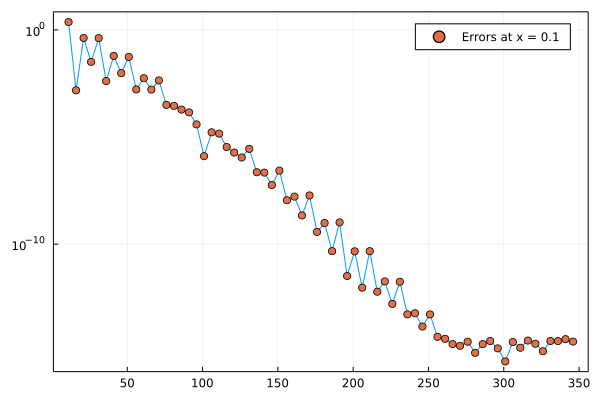

In [42]:
plot(ms,data,yaxis = :log, label = "", grid = true, framestyle = :box)
plot!(ms,data,yaxis = :log, seriestype = :scatter, label = "Errors at x = 0.1")

## Differentiation

To work out how to approximate derivatives, we differentiate

\begin{align*}
I_Nf(x) = \frac{1}{m} \sum_{j = - N_-}^{N_+} \check c_{j}(f) e^{\pi i j x/L}
\end{align*}

giving

\begin{align*}
\frac{d^k}{dx^k} I_Nf(x) = \frac{1}{m} \sum_{\omega = - N_-}^{N_+} \check c_{j}(f) (\pi i j/L)^k e^{\pi i j x/L}
\end{align*}

In [43]:
diffvec = (L,m,k) -> ((-floor(m/2):1:floor((m-1)/2))*(1im*pi/L)).^k

#63 (generic function with 1 method)

In [44]:
function diff(tr::trig_interp,j=1)
    return trig_interp(tr.L,diffvec(L,length(tr.c),j).*tr.c)
end

diff (generic function with 8 methods)

In [46]:
L = 10.
m = 51
X = mgrid(m,L)
f = x -> exp.(-cos.(pi*x/L))
df = x -> f(x).*(pi/L)*sin.(pi*x/L)
fm = trig_interp(L,mfft(f(X)));
dfm = diff(fm);

In [47]:
dfm(.1) - df(.1)

1.7286519438108883e-15 + 4.580519816164263e-16im

In [ ]:
dfm